# 07__motif_coverage
# analyzing how motif coverage correlates with MPRA properties and biotypes; clustering similar motifs

in this notebook, i look at how the coverage metrics (# bp covered and max coverage of motifs; done separately, see methods) look within biotypes *after* limiting to only those motifs which have been validated by a corresponding chip peak. i also make sure the results we see aren't due to redundancies in motif databases, so i cluster the motifs using MoSBAT (done separately using their webtool) and re-calculate the metrics.

------

figures in this notebook:
- **Fig 2D and 2E**: cumulative density plots of # bp covered and max motif coverage across biotypes
- **Fig S7**: heatmap of clustered motifs, and more cumulative density plots (after clustering)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
mosbat_file = "../../misc/02__mosbat/results.from_mosbat.txt"

In [4]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.bed"
cage_expr_f = "../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"

In [5]:
fimo_cov_f = "../../data/04__coverage/all_fimo_map.all_cov.new.txt"
fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersected.all_cov.new.txt"
fimo_clust_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.all_cov.new.txt"
fimo_no_ets_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.all_cov.new.txt"
fimo_no_ets_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersected.no_ETS_motifs.all_cov.new.txt"

pool1_fimo_cov_f = "../../data/04__coverage/pool1_fimo_map.all_cov.new.txt"
pool1_fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersectedall_cov.new.txt"

In [6]:
fimo_phylop_f = "../../misc/03__fimo/04__merged_grouped_beds/all_fimo_map.phylop46way.with_promtype.txt"
fimo_chip_phylop_f = "../../misc/03__fimo/04__merged_grouped_beds/all_fimo_map.chip_intersected.phylop46way.with_promtype.txt"
fimo_clust_phylop_f = "../../misc/03__fimo/04__merged_grouped_beds/all_fimo_map.bulyk_clusters.phylop46way.with_promtype.txt"

In [7]:
all_phylop_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.phylop46way.txt"

In [8]:
fimo_count_f = "../../misc/03__fimo/05__overlap_per_motif/all_fimo_map.all_tfs.txt"
fimo_chip_count_f = "../../misc/03__fimo/05__overlap_per_motif/all_fimo_map.chip_intersected.all_tfs.txt"
fimo_clust_count_f = "../../misc/03__fimo/05__overlap_per_motif/all_fimo_map.bulyk_clusters.all_tfs.txt"

note: the reason why some IDs are not in the expression file is these are FANTOM CAT IDs that for some reason are not present in the FANTOM5 robust set. so, we exclude these.

## 1. import data

In [9]:
corr = pd.read_table(mosbat_file, sep="\t")

In [10]:
fimo_count = pd.read_table(fimo_count_f, sep="\t", header=None)
fimo_count.columns = ["motif", "num", "mean_overlap", "std_overlap"]

fimo_chip_count = pd.read_table(fimo_chip_count_f, sep="\t", header=None)
fimo_chip_count.columns = ["motif", "num", "mean_overlap", "std_overlap"]

fimo_clust_count = pd.read_table(fimo_clust_count_f, sep="\t", header=None)
fimo_clust_count.columns = ["motif", "num", "mean_overlap", "std_overlap"]
fimo_clust_count.head()

,motif,num,mean_overlap,std_overlap
0,AP2,53613,1.78529,1.087430
1,AP4,21870,1.24166,0.504296
2,ARID3,4238,1.27820,0.486487
3,ARID5,5592,1.14861,0.371920
4,AThook_PWWP,8100,1.15469,0.378296


In [11]:
fimo_phylop = pd.read_table(fimo_phylop_f, sep="\t")
fimo_phylop.columns = ["chr", "start", "end", "n_ov_motifs", "size", "phylop", "unique_id"]

fimo_chip_phylop = pd.read_table(fimo_chip_phylop_f, sep="\t")
fimo_chip_phylop.columns = ["chr", "start", "end", "n_ov_motifs", "size", "phylop", "unique_id"]

fimo_clust_phylop = pd.read_table(fimo_clust_phylop_f, sep="\t")
fimo_clust_phylop.columns = ["chr", "start", "end", "n_ov_motifs", "size", "phylop", "unique_id"]
fimo_clust_phylop.sample(5)

,chr,start,end,n_ov_motifs,size,phylop,unique_id
1017697,chr8,12803163,12803164,2,1,-0.71,protein_coding__p17@KIAA1456__chr8:12803146..1...
672869,chr20,22078338,22078339,1,1,-0.05,Enhancer__chr20:22078229-22078315
316235,chr14,68162511,68162512,1,1,1.32,protein_coding__p1@RDH11__chr14:68162464..6816...
223178,chr12,6484337,6484338,1,1,0.47,"protein_coding__p4@LTBR__chr12:6484306..6484392,+"
1137497,chrX,153603046,153603047,3,1,1.67,protein_coding__p3@FLNA__chrX:153602991..15360...


In [12]:
all_phylop = pd.read_table(all_phylop_f, sep="\t")
all_phylop.columns = ["chr", "start", "end", "unique_id", "score", "strand", "size", "num_data", "min", "max",
                      "mean", "median"]
all_phylop.head()

,chr,start,end,unique_id,score,strand,size,num_data,min,max,mean,median
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,115,115,-3.70,2.09,0.26,0.09
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,115,115,-2.46,2.73,0.66,0.49
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,115,115,-3.45,2.18,-0.27,-0.14
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,115,115,-2.98,2.41,0.18,0.21
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,115,115,-2.89,2.36,-0.05,-0.03


In [13]:
fimo_phylop = fimo_phylop.merge(all_phylop[["unique_id", "mean"]], on="unique_id")
fimo_chip_phylop = fimo_chip_phylop.merge(all_phylop[["unique_id", "mean"]], on="unique_id")
fimo_clust_phylop = fimo_clust_phylop.merge(all_phylop[["unique_id", "mean"]], on="unique_id")
fimo_phylop.head()

,chr,start,end,n_ov_motifs,size,phylop,unique_id,mean
0,chr1,564442,564443,4,1,0.35,"intergenic__NA__chr1:564474..564492,-",0.1
1,chr1,564443,564444,4,1,0.35,"intergenic__NA__chr1:564474..564492,-",0.1
2,chr1,564444,564445,4,1,0.42,"intergenic__NA__chr1:564474..564492,-",0.1
3,chr1,564445,564446,4,1,0.35,"intergenic__NA__chr1:564474..564492,-",0.1
4,chr1,564446,564447,4,1,0.00,"intergenic__NA__chr1:564474..564492,-",0.1


In [14]:
fimo_cov = pd.read_table(fimo_cov_f, sep="\t")
fimo_chip_cov = pd.read_table(fimo_chip_cov_f, sep="\t")
fimo_clust_cov = pd.read_table(fimo_clust_cov_f, sep="\t")
fimo_no_ets_cov = pd.read_table(fimo_no_ets_cov_f, sep="\t")
fimo_no_ets_chip_cov = pd.read_table(fimo_no_ets_chip_cov_f, sep="\t")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp
30263,protein_coding__p1@KRTAP10-3__chr21:45978676.....,"chr21:45978676..45978679,-",0,0,0.0,NaN,0.000000,0.000000,0.000000,NaN
8790,Enhancer__chr12:130624608-130625033,chr12:130624608-130625033,1,15,1.0,0.252424,0.693147,2.772589,0.693147,0.225081
51820,Enhancer__chr8:39956643-39956887,chr8:39956643-39956887,0,0,0.0,NaN,0.000000,0.000000,0.000000,NaN
35560,Enhancer__chr3:121771928-121772097,chr3:121771928-121772097,3,26,2.0,0.357982,1.386294,3.295837,1.098612,0.306000
5749,"protein_coding__p1@RNU2-2,p2@WDR74__chr11:6260...","chr11:62609281..62609282,-",0,0,0.0,NaN,0.000000,0.000000,0.000000,NaN


In [15]:
print(len(fimo_cov))
print(len(fimo_chip_cov))
print(len(fimo_clust_cov))

56630
56630
56630


In [16]:
fimo_cov["PromType2"] = fimo_cov["unique_id"].str.split("__", expand=True)[0]
fimo_chip_cov["PromType2"] = fimo_chip_cov["unique_id"].str.split("__", expand=True)[0]
fimo_clust_cov["PromType2"] = fimo_clust_cov["unique_id"].str.split("__", expand=True)[0]
fimo_no_ets_cov["PromType2"] = fimo_no_ets_cov["unique_id"].str.split("__", expand=True)[0]
fimo_no_ets_chip_cov["PromType2"] = fimo_no_ets_chip_cov["unique_id"].str.split("__", expand=True)[0]
fimo_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2
26078,Enhancer__chr19:51104864-51105235,chr19:51104864-51105235,14,48,8.0,0.410676,2.708050,3.891820,2.197225,0.344069,Enhancer
23406,"protein_coding__p@chr18:47363947..47363978,-__...","chr18:47363947..47363978,-",7,47,4.0,0.520429,2.079442,3.871201,1.609438,0.418992,protein_coding
25190,"div_lnc__NA__chr19:36103565..36103576,-","chr19:36103565..36103576,-",52,81,24.0,0.331770,3.970292,4.406719,3.218876,0.286509,div_lnc
46089,protein_coding__p1@AIF1__chr6:31582990..315830...,"chr6:31582990..31583096,+",14,66,8.0,0.342684,2.708050,4.204693,2.197225,0.294671,protein_coding
26417,"protein_coding__NA__chr19:55973703..55973725,-","chr19:55973703..55973725,-",5,45,2.0,0.398385,1.791759,3.828641,1.098612,0.335318,protein_coding


In [17]:
# filter to those that have at least 1 motif so distributions are not 0-skewed
fimo_cov = fimo_cov[fimo_cov["n_motifs"] > 0]
print(len(fimo_cov))

fimo_chip_cov = fimo_chip_cov[fimo_chip_cov["n_motifs"] > 0]
print(len(fimo_chip_cov))

fimo_no_ets_cov = fimo_no_ets_cov[fimo_no_ets_cov["n_motifs"] > 0]
print(len(fimo_no_ets_cov))

fimo_no_ets_chip_cov = fimo_no_ets_chip_cov[fimo_no_ets_chip_cov["n_motifs"] > 0]
print(len(fimo_no_ets_chip_cov))

fimo_clust_cov = fimo_clust_cov[fimo_clust_cov["n_motifs"] > 0]
print(len(fimo_clust_cov))

56567
24371
56559
23080
35177


In [18]:
cage_expr = pd.read_table(cage_expr_f, sep="\t")
cage_expr.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,moderate
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,moderate
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [19]:
fimo_cov = fimo_cov.merge(cage_expr, on="cage_id", how="left")
fimo_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",19,66,7.0,0.452439,2.995732,4.204693,2.079442,0.373244,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100074404-100074582,chr10:100074404-100074582,24,74,9.0,0.498479,3.218876,4.317488,2.302585,0.404451,Enhancer,0.015866,0.993289,0.666667,31.0,tissue-specific
2,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,24,78,8.0,0.341736,3.218876,4.369448,2.197225,0.293965,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
3,Enhancer__chr10:100076500-100076699,chr10:100076500-100076699,19,83,8.0,0.376472,2.995732,4.430817,2.197225,0.319524,Enhancer,0.029745,0.981128,NaN,67.0,moderate
4,Enhancer__chr10:100082942-100083374,chr10:100082942-100083374,34,90,13.0,0.375421,3.555348,4.510860,2.639057,0.318760,Enhancer,0.023984,0.986789,0.666667,47.0,tissue-specific


In [20]:
fimo_chip_cov = fimo_chip_cov.merge(cage_expr, on="cage_id", how="left")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
3214,protein_coding__p9@ZBTB41__chr1:197170394..197...,"chr1:197170394..197170444,-",7,53,4.0,0.304412,2.079442,3.988984,1.609438,0.265753,protein_coding,10.059053,0.774660,0.199456,544.0,ubiquitous
19111,Enhancer__chr6:109672770-109673128,chr6:109672770-109673128,1,17,1.0,0.470165,0.693147,2.890372,0.693147,0.385375,Enhancer,NaN,NaN,NaN,NaN,NaN
9916,Enhancer__chr17:76641957-76642289,chr17:76641957-76642289,4,33,2.0,0.213540,1.609438,3.526361,1.098612,0.193542,Enhancer,0.326058,0.990293,0.666667,120.0,moderate
12287,protein_coding__p1@CDK5RAP1__chr20:31989307..3...,"chr20:31989307..31989346,-",6,33,5.0,0.429090,1.945910,3.526361,1.791759,0.357038,protein_coding,20.323836,0.690794,0.131088,549.0,ubiquitous
20800,protein_coding__p2@ARL4A__chr7:12726474..12726...,"chr7:12726474..12726542,+",2,13,2.0,0.335821,1.098612,2.639057,1.098612,0.289546,protein_coding,7.590227,0.901569,0.262010,536.0,ubiquitous


In [21]:
fimo_clust_cov = fimo_clust_cov.merge(cage_expr, on="cage_id", how="left")
fimo_clust_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",8,62,3.0,2.197225,4.143135,1.386294,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,1,13,1.0,0.693147,2.639057,0.693147,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
2,protein_coding__p1@PYROXD2__chr10:100174900..1...,"chr10:100174900..100174956,-",4,39,1.0,1.609438,3.688879,0.693147,protein_coding,5.764484,0.872210,0.547032,508.0,ubiquitous
3,protein_coding__p1@HPS1__chr10:100206642..1002...,"chr10:100206642..100206717,-",9,54,3.0,2.302585,4.007333,1.386294,protein_coding,30.877938,0.777160,0.192167,546.0,ubiquitous
4,protein_coding__p1@HPSE2__chr10:100995440..100...,"chr10:100995440..100995474,-",9,49,5.0,2.302585,3.912023,1.791759,protein_coding,0.639976,0.966872,NaN,142.0,moderate


In [22]:
chip_cov_exp = fimo_chip_cov[~pd.isnull(fimo_chip_cov["av_exp"])]
motif_cov_exp = fimo_cov[~pd.isnull(fimo_cov["av_exp"])]
cluster_cov_exp = fimo_clust_cov[~pd.isnull(fimo_clust_cov["av_exp"])]

In [23]:
motif_cov_exp.PromType2.value_counts()

Enhancer          17864
protein_coding    13441
intergenic         1531
div_pc             1302
div_lnc             674
antisense           622
Name: PromType2, dtype: int64

In [24]:
chip_cov_exp.PromType2.value_counts()

protein_coding    9020
Enhancer          7781
div_pc            1039
intergenic         632
div_lnc            533
antisense          259
Name: PromType2, dtype: int64

In [25]:
cluster_cov_exp.PromType2.value_counts()

protein_coding    13016
Enhancer           5504
intergenic         1405
div_pc             1278
div_lnc             665
antisense           586
Name: PromType2, dtype: int64

## 2. plot # bp covered & max cov across biotypes

### all motifs

(2, 5)

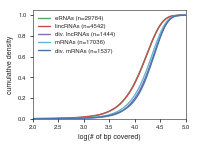

In [26]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_xlim((2, 5))

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.83376919901e-07
ub/dy pval: 0.00266050801699
ts/dy pval: 0.00159653354347
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.04489610269e-10
ub/dy pval: 6.56115180385e-07
ts/dy pval: 0.193145614484
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 7.38006595368e-81
ub/dy pval: 1.05398926386e-38
ts/dy pval: 0.10367566765


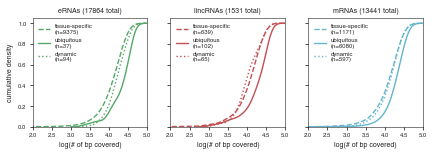

In [27]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-specific\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiquitous\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper left")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

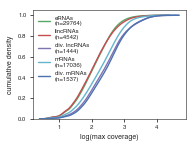

In [28]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
ax.legend(loc="upper left")
fig.savefig("max_cov.all_biotypes.for_poster.pdf", dpi="figure", bbox_inches="tight")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 1.40235544333e-07
ub/dy pval: 5.19162012054e-05
ts/dy pval: 0.794532288544
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 3.67153570438e-09
ub/dy pval: 0.000130464982636
ts/dy pval: 0.961060906222
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 2.628633318e-109
ub/dy pval: 3.60001528522e-59
ts/dy pval: 0.677432320012


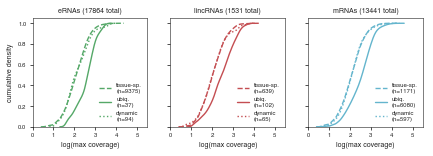

In [29]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 5.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

### ChIP-validated motifs

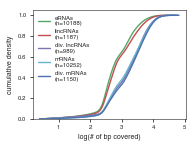

In [30]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.44244771961e-13
ub/dy pval: 7.76107144661e-06
ts/dy pval: 0.0182654230167
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 3.26651186931e-18
ub/dy pval: 0.00103399973145
ts/dy pval: 0.166476954009
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 1.61130225415e-57
ub/dy pval: 6.48963762606e-36
ts/dy pval: 0.591343349112


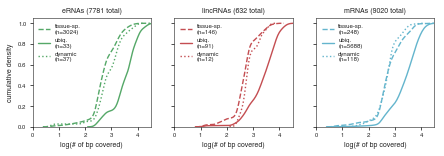

In [31]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (0, 4.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2D_biotype_split.pdf", bbox_inches="tight", dpi="figure")

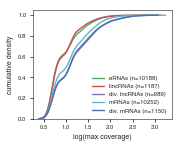

In [32]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 5.27934882732e-07
ub/dy pval: 0.00131904775824
ts/dy pval: 0.818176799935
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 2.5296559515e-14
ub/dy pval: 0.0115970944988
ts/dy pval: 0.42579750287
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 1.45757676499e-34
ub/dy pval: 4.24557245531e-16
ts/dy pval: 0.372862987686


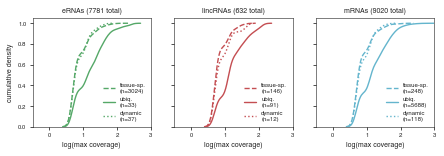

In [33]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2E_biotype_split.pdf", bbox_inches="tight", dpi="figure")

### clustered motifs

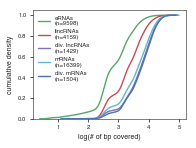

In [34]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
#fig.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.191037999494
ub/dy pval: 0.635933482817
ts/dy pval: 0.325866833835
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.10717986231e-16
ub/dy pval: 4.8172696698e-08
ts/dy pval: 0.657174107118
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 3.99118798087e-154
ub/dy pval: 6.08190711452e-87
ts/dy pval: 0.454658327754


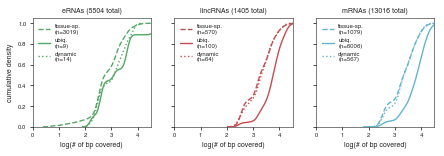

In [35]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (0, 4.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
#f.savefig("Fig_2D_biotype_split.pdf", bbox_inches="tight", dpi="figure")

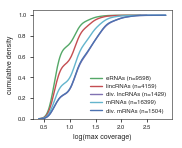

In [36]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
#fig.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.0155561437566
ub/dy pval: 0.172366647173
ts/dy pval: 0.485721693814
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.04122334286e-14
ub/dy pval: 0.000120913230145
ts/dy pval: 0.153207754556
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 1.12703217663e-103
ub/dy pval: 1.14793361199e-60
ts/dy pval: 0.769440458532


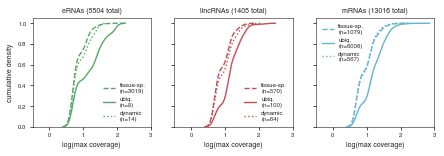

In [37]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
#f.savefig("Fig_2E_biotype_split.pdf", bbox_inches="tight", dpi="figure")

## 2. cluster the motifs using MoSBAT output

In [38]:
corr.set_index(corr["Motif"], inplace=True)
corr.drop("Motif", axis=1, inplace=True)
corr.head()

,RUNX1,TFAP2A,Arnt,Ahr..Arnt,Ar,T,PAX5,NR2F1,CREB1,Ddit3..Cebpa,...,HOXC12,HOXC13,HOXD11,HOXD13,Hoxd8,Hoxa11,Hoxd3,Hoxd9,ISL2,Hes1
Motif,,,,,,,,,,,,,,,,,,,,,
RUNX1,1.000000,0.053362,-0.045079,0.084369,-0.044827,-0.011180,0.009678,0.023699,0.031270,-0.042494,...,-0.046124,-0.054724,-0.089790,-0.021027,-0.038859,-0.082215,0.014631,-0.013418,0.029031,-0.012669
TFAP2A,0.053362,1.000000,0.060590,0.040435,0.008935,-0.033231,0.083051,0.072317,0.036212,0.012966,...,-0.142886,-0.121405,-0.172917,-0.117810,-0.184969,-0.147377,-0.089514,-0.148299,-0.072275,0.146438
Arnt,-0.045079,0.060590,1.000000,0.355305,0.065284,0.121252,-0.006139,0.048724,0.153955,0.042929,...,-0.020919,-0.022952,-0.059050,-0.077210,-0.123874,-0.067242,-0.082448,-0.073004,-0.047794,0.694827
Ahr..Arnt,0.084369,0.040435,0.355305,1.000000,0.040715,0.127365,0.061560,-0.000861,0.066961,0.022640,...,-0.027722,-0.025836,-0.058218,-0.043445,-0.090282,-0.037421,-0.068454,-0.048630,-0.033096,0.441696
Ar,-0.044827,0.008935,0.065284,0.040715,1.000000,-0.031151,-0.056479,-0.006634,0.013517,0.005174,...,-0.013779,-0.011751,-0.022109,-0.054133,-0.060648,-0.024212,0.004521,-0.034178,0.023124,0.081356


In [39]:
row_linkage = hierarchy.linkage(distance.pdist(corr, 'correlation'), method="average")
col_linkage = hierarchy.linkage(distance.pdist(corr.T, 'correlation'), method="average")

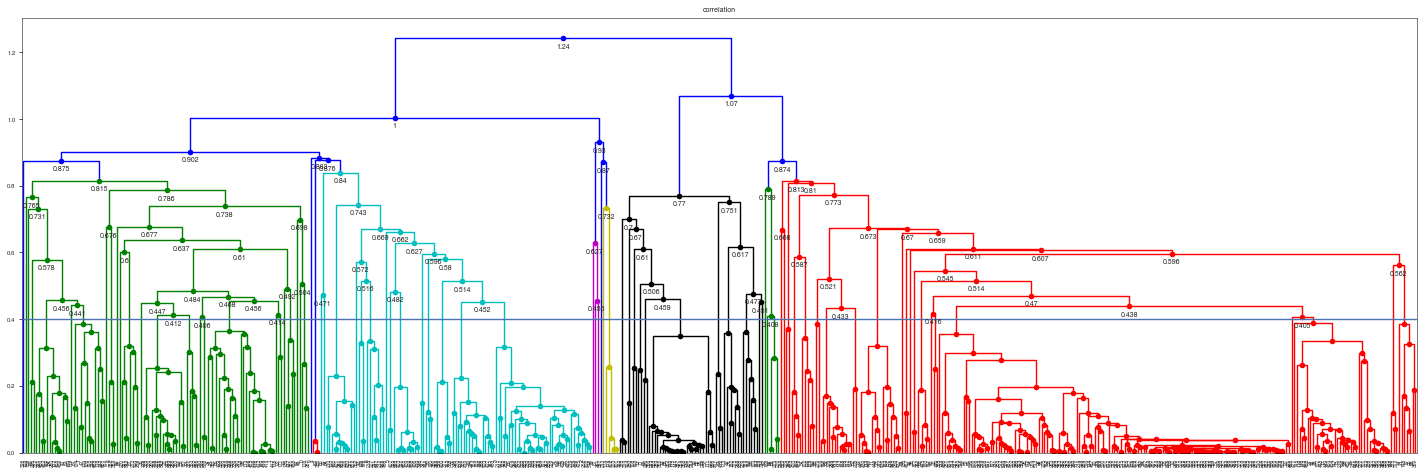

In [40]:
dists = plot_dendrogram(row_linkage, 0.4, "correlation")

In [41]:
clusters = hierarchy.fcluster(row_linkage, 0.1, criterion="distance")

In [42]:
print("n clusters: %s" % np.max(clusters))

n clusters: 223


In [43]:
cluster_map = pd.DataFrame.from_dict(dict(zip(list(corr.index), clusters)), orient="index")
cluster_map.columns = ["cluster"]
cluster_map.head()

,cluster
RUNX1,71
TFAP2A,55
Arnt,114
Ahr..Arnt,116
Ar,75


In [44]:
cluster_map.loc["BHLHE40"]

cluster    110
Name: BHLHE40, dtype: int64

## 3. plot clustered motif heatmap

In [45]:
colors = sns.husl_palette(np.max(clusters), s=0.75)
shuffle(colors)
lut = dict(zip(range(np.min(clusters), np.max(clusters)+1), colors))
row_colors = cluster_map["cluster"].map(lut)

In [46]:
cmap = sns.cubehelix_palette(8, start=.5, light=1, dark=0.25, hue=0.9, rot=-0.75, as_cmap=True)

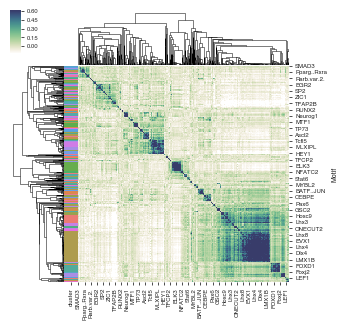

In [47]:
cg = sns.clustermap(corr, method="average", row_linkage=row_linkage, robust=True,
                    col_linkage=col_linkage, cmap=cmap, figsize=(5, 5), row_colors=row_colors,
                    linewidths=0, rasterized=True)
cg.savefig("Fig_S7A.pdf", bbox_inches="tight", dpi="figure")

In [48]:
cluster_map.to_csv("../../misc/02__mosbat/cluster_map.txt", sep="\t", index=True)

## 4. re-plot # bp covered and max coverage per biotype *after* clustering
note that i sent the cluster results to marta, who re-ran her coverage scripts using them, and i re-upload them in this notebook (so in real life there is a break between the above part and the following part of this notebook)

10/22/18 NOTE: MARTA NEEDS TO REDO THIS PART, OR WE CUT

In [49]:
cluster_cov["log_bp_covered"] = np.log(cluster_cov["numBPcovered"]+1)
cluster_cov["log_max_cov"] = np.log(cluster_cov["MaxCov"]+1)

cluster_cov_exp["log_bp_covered"] = np.log(cluster_cov_exp["numBPcovered"]+1)
cluster_cov_exp["log_max_cov"] = np.log(cluster_cov_exp["MaxCov"]+1)

NameError: name 'cluster_cov' is not defined

In [ ]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((2.5,5))
fig.savefig("Fig_S7B.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_covered"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7B_biotype_split.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(max coverage, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((0, 2.75))
fig.savefig("Fig_S7C.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7C_biotype_split.pdf", bbox_inches="tight", dpi="figure")

## 5. find good examples of lots of motifs and few motifs

In [52]:
motif_cov_exp.sort_values(by=["av_exp", "max_cov"], ascending=False).head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
25944,protein_coding__p1@FTL__chr19:49468563..494685...,"chr19:49468563..49468567,+",15,79,6.0,0.365316,2.772589,4.382027,1.945910,0.311386,protein_coding,3121.218149,0.951336,0.477238,550.0,ubiquitous
16414,protein_coding__p1@B2M__chr15:45003704..450037...,"chr15:45003704..45003724,+",26,75,9.0,0.348160,3.295837,4.330733,2.302585,0.298741,protein_coding,2383.028229,0.936382,0.523603,550.0,ubiquitous
2069,protein_coding__p1@RPS24__chr10:79793612..7979...,"chr10:79793612..79793631,+",18,69,14.0,0.417528,2.944439,4.248495,2.708050,0.348915,protein_coding,2335.912420,0.840886,0.231686,550.0,ubiquitous
26389,protein_coding__p1@RPL28__chr19:55897297..5589...,"chr19:55897297..55897303,+",30,91,17.0,0.437745,3.433987,4.521789,2.890372,0.363076,protein_coding,2328.610023,0.818471,0.297636,550.0,ubiquitous
13062,"div_pc__p1@TPT1__chr13:45915315..45915321,-","chr13:45915315..45915321,-",45,109,15.0,0.410342,3.828641,4.700480,2.772589,0.343832,div_pc,2151.582247,0.812062,0.285229,550.0,ubiquitous


In [119]:
clust_cov_exp_tss = cluster_cov_exp[cluster_cov_exp["PromType2"] != "Enhancer"]
chip_cov_exp_tss = chip_cov_exp[chip_cov_exp["PromType2"] != "Enhancer"]
tss_merge = clust_cov_exp_tss.merge(chip_cov_exp_tss, on=["unique_id", "cage_id"], suffixes=("_clust", "_chip"))
tss_merge = tss_merge[["unique_id", "n_motifs_chip", "n_motifs_clust", "max_cov_clust", "max_cov_chip", "av_exp_chip", "tissue_sp_all_chip", "tss_type_chip"]]
tss_merge.sample(5)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
6149,protein_coding__p1@NCOA3__chr20:46130619..4613...,2,6,3.0,1.0,32.751525,0.951237,ubiquitous
5818,protein_coding__p1@ZNF671__chr19:58238958..582...,6,7,4.0,5.0,3.629355,0.884969,moderate
2566,protein_coding__p1@USPL1__chr13:31192040..3119...,4,2,1.0,3.0,4.948612,0.817276,ubiquitous
2488,protein_coding__p1@PROZ__chr13:113812956..1138...,1,5,2.0,1.0,0.183722,0.995469,tissue-specific
43,"div_pc__p1@TRIM8__chr10:104404218..104404252,+",1,5,3.0,1.0,3.939736,0.858760,ubiquitous


In [129]:
tss_merge[(tss_merge["unique_id"].str.contains("intergenic")) & (tss_merge["tss_type_chip"] == "ubiquitous")].sort_values(by=["max_cov_chip", "max_cov_clust"], ascending=False).head(40)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
1749,intergenic__p1@LINC00467__chr1:211556107..2115...,9,8,4.0,7.0,13.950864,0.950737,ubiquitous
5227,"intergenic__p1@BC067908__chr19:1876156..1876202,-",14,10,3.0,7.0,3.588906,0.939805,ubiquitous
7681,intergenic__p1@ENST00000453671__chr3:194304713...,11,8,3.0,7.0,4.764732,0.882028,ubiquitous
9867,intergenic__p1@LINC00265__chr7:39773160..39773...,11,5,3.0,7.0,4.408643,0.920643,ubiquitous
10183,"intergenic__p1@ENST00000517411,p1@ENST00000518...",9,5,2.0,7.0,9.121277,0.796281,ubiquitous
434,"intergenic__p1@ENST00000416301,p1@ENST00000444...",8,8,2.0,6.0,3.519481,0.860135,ubiquitous
494,intergenic__p1@SCARNA2__chr1:109642799..109642...,12,5,2.0,6.0,723.827417,0.955894,ubiquitous
10811,intergenic__p1@LOC100506710__chr9:37079888..37...,10,10,4.0,5.0,10.223753,0.797721,ubiquitous
6059,intergenic__p1@LOC647979__chr20:34638841..3463...,6,6,3.0,5.0,17.469752,0.829929,ubiquitous
349,"intergenic__p1@AGAP5,p1@BMS1P4__chr10:75490225...",6,4,2.0,5.0,6.799350,0.793227,ubiquitous


In [76]:
tss_merge[(tss_merge["tss_type_chip"] == "tissue-specific") & (tss_merge["n_motifs_chip"] > 1)].sort_values(by=["max_cov_chip", "max_cov_clust"], ascending=True).head(50)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
204,protein_coding__p5@MTPAP__chr10:30663371..3066...,2,2,1.0,1.0,0.088347,0.997435,tissue-specific
217,protein_coding__p4@GJD4__chr10:35894364..35894...,2,1,1.0,1.0,0.006755,0.997258,tissue-specific
249,protein_coding__p3@GDF2__chr10:48416849..48416...,2,3,1.0,1.0,0.024819,0.995522,tissue-specific
838,"intergenic__p1@ENST00000499194,p1@uc001mxu.1__...",3,2,1.0,1.0,0.005056,0.998146,tissue-specific
1044,protein_coding__p1@FCRL4__chr1:157567868..1575...,2,2,1.0,1.0,0.041793,0.993949,tissue-specific
1752,intergenic__p1@ENST00000547114__chr12:11698589...,2,2,1.0,1.0,0.106108,0.995931,tissue-specific
2038,intergenic__p1@ENST00000442382__chr1:234831899...,2,4,1.0,1.0,0.013866,0.986447,tissue-specific
2938,"intergenic__p1@ENST00000554328,p1@ENST00000556...",2,1,1.0,1.0,0.026629,0.997789,tissue-specific
3039,antisense__p1@ENST00000554918__chr14:65007081....,3,1,1.0,1.0,0.009981,0.993361,tissue-specific
3047,"intergenic__p1@ENST00000556291,p1@ENST00000556...",2,3,1.0,1.0,0.008986,0.998159,tissue-specific


## 3. look at conservation of nucleotides vs. motif coverage

In [49]:
fimo_phylop_f = "../../misc/03__fimo/06__phylop_meta_plot/all_fimo_map.phylop46way.txt"
fimo_chip_phylop_f = "../../misc/03__fimo/06__phylop_meta_plot/all_fimo_map.chip_intersected.phylop46way.txt"
fimo_clust_phylop_f = "../../misc/03__fimo/06__phylop_meta_plot/all_fimo_map.bulyk_clusters.phylop46way.txt"

In [52]:
fimo_phylop = pd.read_table(fimo_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "motif", "n_ov", "tss_dist"]
cols.extend(np.arange(-150, 150, step=1))
fimo_phylop.columns = cols
fimo_phylop.head()

,chr,start,end,motif,n_ov,tss_dist,-150,-149,-148,-147,...,140,141,142,143,144,145,146,147,148,149
0,chr1,564296,564596,ESRRB,14,2,-0.62,-0.47,0.93,-0.03,...,-1.17,0.41,-0.44,0.48,0.41,-1.83,-0.38,0.41,-0.44,-1.17
1,chr1,564296,564596,NR4A2,14,2,-0.62,-0.47,0.93,-0.03,...,-1.17,0.41,-0.44,0.48,0.41,-1.83,-0.38,0.41,-0.44,-1.17
2,chr1,564297,564597,Esrrg,14,2,-0.47,0.93,-0.03,0.05,...,0.41,-0.44,0.48,0.41,-1.83,-0.38,0.41,-0.44,-1.17,-1.73
3,chr1,564297,564597,Esrra,14,2,-0.47,0.93,-0.03,0.05,...,0.41,-0.44,0.48,0.41,-1.83,-0.38,0.41,-0.44,-1.17,-1.73
4,chr1,564308,564608,NR2F1,14,1,0.68,-0.89,0.77,-2.23,...,0.41,0.48,-1.71,-0.68,-0.73,-1.14,-0.80,0.48,-1.37,-0.65


In [116]:
res_dict = {}
df = fimo_phylop
nuc_cols = list(np.arange(-150, 150, step=1))

prev_max = 0
for max_motifs in [1, 10, 30, 86]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    signs = np.asarray(sub["tss_dist"].astype(int))
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

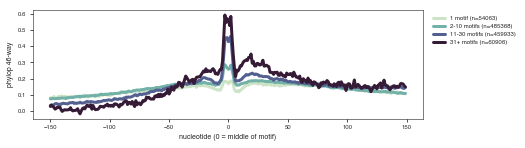

In [117]:
fig = plt.figure(figsize=(7,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 10: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           30: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 86: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-10 motifs", "11-30 motifs", "31+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.25, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")

In [120]:
fimo_chip_phylop = pd.read_table(fimo_chip_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "motif", "n_ov", "tss_dist"]
cols.extend(np.arange(-150, 150, step=1))
fimo_chip_phylop.columns = cols
fimo_chip_phylop.head()

,chr,start,end,motif,n_ov,tss_dist,-150,-149,-148,-147,...,140,141,142,143,144,145,146,147,148,149
0,chr1,713832,714132,YY1,2,2,0.13,0.13,0.15,0.13,...,0.13,-1.79,0.15,0.15,0.13,0.13,0.13,0.15,-1.54,0.16
1,chr1,713835,714135,E2F1,2,2,0.13,0.13,0.13,0.13,...,0.15,0.13,0.13,0.13,0.15,-1.54,0.16,0.14,0.14,0.16
2,chr1,713920,714220,JUN,1,-,0.14,0.16,0.16,-1.63,...,0.15,0.13,0.15,0.15,0.13,0.15,0.15,0.15,0.15,0.15
3,chr1,713942,714242,Atf1,2,-,-1.57,-1.51,-1.90,0.16,...,0.15,0.13,0.15,0.13,0.15,0.13,0.15,0.15,-1.37,0.15
4,chr1,713941,714241,Atf1,2,8,-1.82,0.15,-1.37,0.15,...,0.14,-1.89,-1.63,-1.53,0.14,0.16,0.14,0.16,-1.90,-1.51


In [121]:
fimo_chip_phylop["n_ov"].max()

13

In [127]:
res_dict = {}
df = fimo_chip_phylop
nuc_cols = list(np.arange(-150, 150, step=1))

prev_max = 0
for max_motifs in [1, 4, 8, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

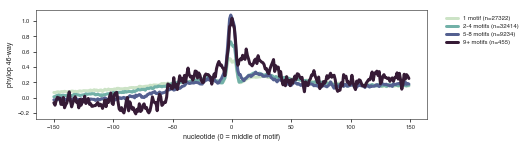

In [128]:
fig = plt.figure(figsize=(7,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 4: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           8: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-4 motifs", "5-8 motifs", "9+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.25, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")

In [129]:
fimo_clust_phylop = pd.read_table(fimo_clust_phylop_f, sep="\t", header=None)
fimo_clust_phylop.columns = cols
fimo_clust_phylop.head()

,chr,start,end,motif,n_ov,tss_dist,-150,-149,-148,-147,...,140,141,142,143,144,145,146,147,148,149
0,chr1,564308,564608,ESRR-II,3,1,0.68,-0.89,0.77,-2.23,...,0.41,0.48,-1.71,-0.68,-0.73,-1.14,-0.80,0.48,-1.37,-0.65
1,chr1,564308,564608,zfC4,3,1,0.68,-0.89,0.77,-2.23,...,0.41,0.48,-1.71,-0.68,-0.73,-1.14,-0.80,0.48,-1.37,-0.65
2,chr1,564309,564609,TCF7,3,9,-0.89,0.77,-2.23,-0.03,...,0.48,-1.71,-0.68,-0.73,-1.14,-0.80,0.48,-1.37,-0.65,-1.14
3,chr1,564359,564659,ZFX,1,-,0.48,-1.37,-0.38,0.48,...,-0.39,0.02,-0.39,0.05,-0.38,-0.38,-0.04,0.76,0.76,0.92
4,chr1,713881,714181,MYB,1,-,0.16,-1.29,0.16,0.16,...,0.15,0.15,0.15,0.13,-1.37,0.15,0.15,0.13,0.15,0.13


In [130]:
fimo_clust_phylop["n_ov"].max()

13

In [135]:
res_dict = {}
df = fimo_clust_phylop
nuc_cols = list(np.arange(-150, 150, step=1))

prev_max = 0
for max_motifs in [1, 3, 6, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

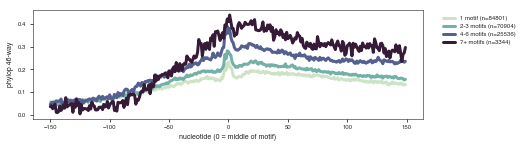

In [137]:
fig = plt.figure(figsize=(7,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 3: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           6: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-3 motifs", "4-6 motifs", "7+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.25, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")